# Part 2 NLP with Wine Reviews

This is **Part 2: NLP with Wine Reviews** of the project. In Part 1, I cleaned the data from the jupyter notebook named Part 1: Clean Wine Reviews and I as well considered feature engineering. I extracted the year from the title column to include vintage as a new feature. Now that the data is cleaned, I will need to run NLP (Natural Language Processing) before I can run any machine learning on the data. The text columns in this dataset are Country (i.e. Italy), Province (i.e. Sicily), Variety (i.e. Pinot Noir), and Description (Wine Review). I will use a One-Hot-Encorder process for the Province, Country, and Variety and I will use the TF-IDF process for wine review descriptions.

As a reference: The original source of this dataset is from [Here](https://www.kaggle.com/zynicide/wine-reviews).

In [11]:
# Import packages
import pandas as pd
import numpy as np

# Import for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# NLTK Packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### 1. Load the data

In [12]:
# load train and test data
df_train = pd.read_csv('data/train_clean.csv')
df_test = pd.read_csv('data/test_clean.csv')

In [13]:
# Load y_train and y_test and save them as a column named points in the df dataframe.
df_train['points'].to_csv (r'y_train.csv', index = False)
df_test['points'].to_csv (r'y_test.csv', index = False)

In [14]:
# Check the train and test shapes to make sure the column numbers are the same. 
# As well as the train test should be larger then the test set.
print('Train set size:', df_train.shape)
print('Test set size:', df_test.shape)

Train set size: (90979, 7)
Test set size: (38992, 7)


### 2. Check Dependent Variable (Wine Scores) distribution

Supervised Learning fall into either Classification or Regression models. Classification models predict a dependent variable that is categorical, and a Regression model predicts a dependent variable that is a measurement or count.

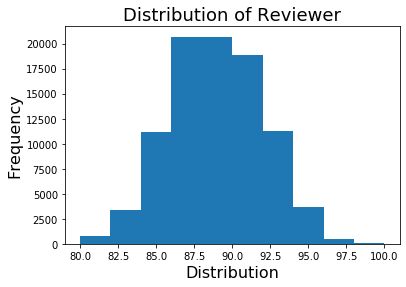

In [15]:
# View the distriubtion of wine scores
plt.figure()
plt.hist(df_train['points'],10)
plt.xlabel('Distribution', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Distribution of Reviewer', fontsize = 18)
plt.show()

The wine score ranges between 80 - 100. There are a couple different ways to treat this for predicting the wine scores. 1) Wine method is treat these scores as 20 classifiers which would be very difficult to predict. 2) Another method is to break the scores into "good" and "bad" scores thus creating a two classifier problem. 3) Model the 80-100 with a regressor model and treat the scores as continuous.

I will first start with a two classifier problem where good scores range between 90 - 100 and bad scores range between 80-89. For this setup I will use Logistic Regression, Random Forest, and XGboost to predict the wine scores. If there is more time then I will also try to predict the scores from 80 - 100 by using a regression model such as using KNN Regressor and Random Forest Regressor.

### 3. Set y values to 0 and 1 (2 classifications)

In [16]:
# Make copy of the train/test dataset before making changes to the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [17]:
# make a new dataframe for setting the distribution of reviewer to 2 classifications
df_train_class = df_train.copy()
df_test_class = df_test.copy()

In [18]:
# map the points to 0 and 1 for train dataset
conversion_dict = {80:0, 81:0, 82:0, 83:0, 84:0, 85:0, 86:0, 87:0, 88:0, 89:1, 90:1, 91:1, 92:1, 93:1, 94:1, 95:1, 96:1, 97:1, 98:1, 99:1, 100:1}
df_train_class['points'] = df_train_class['points'].map(conversion_dict)

# Check to make sure the points have changed to 0 and 1
df_train_class.head()

,country,description,price,province,variety,vintage,points
0,US,A very dark color and extremely concentrated f...,42.0,California,Petite Sirah,2013.0,1
1,US,"An indifferent wine, hot and baked, with jammy...",10.0,California,Meritage,2009.0,0
2,Portugal,Dominated by its tannins and woody characteris...,17.0,Alentejano,Portuguese Red,2011.0,0
3,US,"This wine's unusual purple fruit, citrus, herb...",30.0,Washington,Malbec,2013.0,0
4,Italy,"Elegant yet extremely accessible, this present...",30.0,Central Italy,Lambrusco di Sorbara,2010.0,1


In [19]:
# map the points to 0 and 1 for test dataset
conversion_dict = {80:0, 81:0, 82:0, 83:0, 84:0, 85:0, 86:0, 87:0, 88:0, 89:1, 90:1, 91:1, 92:1, 93:1, 94:1, 95:1, 96:1, 97:1, 98:1, 99:1, 100:1}
df_test_class['points'] = df_test_class['points'].map(conversion_dict)

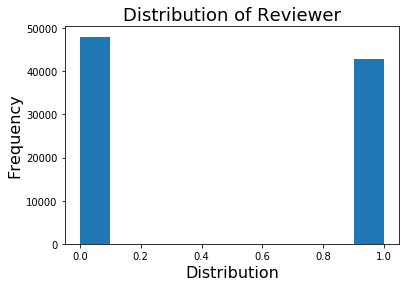

In [20]:
# View the distribution of wine scores
plt.figure()
plt.hist(df_train_class['points'],10)
plt.xlabel('Distribution', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Distribution of Reviewer', fontsize = 18)
plt.show()

There are more "bad" reviews than "good" reviews therefore the model will be able to predict bad reviews better than reviews that are good. While I could downsample the data to make the total amount of good and bad reviews equal, for now I will keep the data how it is as the difference isn't too "large". I will first take a look at the precision and recall scores before downsamplting. The reason for this is because I want to avoid removing data as much as possible because more data points helps improve the training of a model. If the precision and recall scores are low compared to the accuracy score, then I might want to consider downsampling. Note in the future I could also upsample as another approach.

In [21]:
# Set y values for test and train
y_train = df_train['points']
y_test = df_test['points']

In [22]:
# Set y and test values with only 0 ("bad") and 1 ("good") values and rename y values so that we keep the original y values.
y_train_class = df_train_class['points']
y_test_class = df_test_class['points']

In [23]:
# Now that we have the y values, drop the points column from the X dataframe
X_train = df_train_copy.drop('points', axis = 1)

# Repeat with test
X_test = df_test_copy.drop('points', axis = 1)

# View train dataset to make sure the dataframe looks "OK"
X_train.head()

,country,description,price,province,variety,vintage
0,US,A very dark color and extremely concentrated f...,42.0,California,Petite Sirah,2013.0
1,US,"An indifferent wine, hot and baked, with jammy...",10.0,California,Meritage,2009.0
2,Portugal,Dominated by its tannins and woody characteris...,17.0,Alentejano,Portuguese Red,2011.0
3,US,"This wine's unusual purple fruit, citrus, herb...",30.0,Washington,Malbec,2013.0
4,Italy,"Elegant yet extremely accessible, this present...",30.0,Central Italy,Lambrusco di Sorbara,2010.0


### 4. TF-IDF Vectorizer

In [24]:
# Import TFIDF Vectorizer package from Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF Vectorizer will be used for the wine reviews as the process takes a sentance and extracts the word from the sentance and gives it a weight. 

In [27]:
import string

import nltk
stemmer = nltk.stem.PorterStemmer()

nltk.download('stopwords')
from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avielstern/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I decided to not use n_grams which finds group of words in a sentance that contains not i.e. will not go back there again. This is because the wine reviews do not have sentiment. Instead the wine reviews give a more professional tone that describes characteristics of the wine such is the wine acidic, are there tannins, fruity, fresh and so on.

min_df is a threshold that removes any token that has a frequency less than the given parameter. The default is set to 1 and if the threshold ranges between 0 - 1 as a float than the the threshold is a percentage of the porportion of tokens in a document. If the threshold is set as an int than the threshold is the frequency of tokens a document.

In [26]:
# Instantiate
tfidf = TfidfVectorizer(min_df = 0.01, tokenizer=my_tokenizer)

In [17]:
# Create review 
train_review = X_train['description']
test_review = X_test['description']


# Fit reviews
tfidf.fit(train_review)

# Transform reviews
review_train = tfidf.transform(train_review)
review_test = tfidf.transform(test_review)

# Make sure train and test shape contain the same number of rows. 
# This is just reassurance that the tranformation worked.
print(review_train.shape)
print(review_test.shape)

(90979, 415)
(38992, 415)


In [18]:
# View tokens associated to their weight for the train dataset
word_weights = np.array(np.sum(review_train, axis=0)).reshape((-1,))

words = np.array(tfidf.get_feature_names())
words_df = pd.DataFrame({"word": words, 
                         "weight": word_weights})

In [19]:
words_df

,word,weight
0,10,332.911648
1,100,408.617714
2,2016,372.947815
3,2017,504.512139
4,2018,599.444599
...,...,...
410,yet,836.920752
411,young,780.630935
412,youth,305.916007
413,zest,602.166573


In [20]:
# Save the dataframe to a csv which can be used to make further analysis
words_df.to_csv (r'NLP_weights_train.csv', index = False)

In [21]:
# Create a dataframe of the tokenized words. 
# Will also need to use .toarray() to remove sparcity. 

description_train = pd.DataFrame(columns=tfidf.get_feature_names(), data=review_train.toarray())
description_test = pd.DataFrame(columns=tfidf.get_feature_names(), data=review_test.toarray())

In [22]:
# To make sure the TF-IDF worked and that the index looks OK, columns looks OK and so on.
display(description_train)

,10,100,2016,2017,2018,2019,2020,accent,acid,add,...,wood,would,wrap,year,yellow,yet,young,youth,zest,zesti
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.233790,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.241324,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125386,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.243582,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.186656,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.400992
90975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131732,0.0,...,0.000000,0.0,0.0,0.000000,0.267229,0.000000,0.0,0.0,0.0,0.000000
90976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.248652,0.0,0.0,0.0,0.000000
90977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


### 5. Use One Hot Encoding to transform Province, Country, and Variety into 1 or 0. 

One Hot Encoding takes a category and assigns it as its own column in a dataframe. The columns are then filled with 1 or 0. To complete this task, I ended up using three approaches for this which resulted into an iterative workflow process. 
   
**Approach 1:** The first approach I used the function pd.get_dummies on Province, Country, and Variety. After applying get_dummies, I concat Province, Country, Variety, Description into one dataframe. The problem that I ran into which I did not forsee was that the test dataset contained different variables than the train dataset which meant the dataframe sizes were different shapes. This happened because when I split the train and test set. This is more likely to happen with columns that have many categories. I became aware of this problem after fitting a model on the train dataset and realizing that the model would not be able to run for the test dataset.

In the train dataset:

In [23]:
print('Number of countries in train set:', len(df_train['country'].groupby(df_train['country']).count()))
print('Number of province in train set:', len(df_train['province'].groupby(df_train['province']).count()))
print('Number of variety in train set:', len(df_train['variety'].groupby(df_train['variety']).count()))


Number of countries in train set: 42
Number of province in train set: 406
Number of variety in train set: 646


**Approach 2:** I then used a second approach to fix this where I set a threshold to remove any countries, provinces, and varieties that has a percentage of less than 0.5% in the total column. While this approach technically "worked", two issues arised when completing this task. First, I had to peak into the test dataset to make sure that the same countries, varieties, and provinces were in the train dataset as in the test dataset before running the predictive models. The second issue was that the accuracy score was 50% which is low. The reason for such a low accuracy score is because I removed too many variables when setting the threshold. Countries had dropped from a count of 42 to 12, province had dropped from a count of 406 to 34 and variety had dropped from a count of 646 to 34!
    
**Approach 3:** Thanks to this [site](https://www.kaggle.com/learn-forum/50008), I found a solution. We can create a train and test set, run get dummies and then create a new dataframe of the test dataset which only includes get_dummy features from the train set.

### Approach 1

In [24]:
# make copies of X and y dataset so that the original dataset is not changed
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()

# One hot encoding for country, province, and variety
dummy_train = X_train_copy.drop(['description', 'price', 'vintage'], axis = 1)
dummy_test = X_test_copy.drop(['description', 'price', 'vintage'], axis = 1)

# Add columns country, province, variety
cat_columns=["country", "province", "variety"]

# One Hot Encoding
dummy_train= pd.get_dummies(dummy_train, prefix_sep="__", columns=cat_columns)

cat_columns=["country", "province", "variety"]
dummy_test= pd.get_dummies(dummy_test, prefix_sep="__", columns=cat_columns)

# Now that we have use nlp on the text columns, we need to remove these columns
X_train_copy.drop(['country', 'description', 'province', 'variety'], axis = 1, inplace = True)
X_test_copy.drop(['country', 'description', 'province', 'variety'], axis = 1, inplace = True)

# add all columns back to a final X dataframe
X_train_final = pd.concat([description_train, dummy_train, X_train_copy], axis = 1, sort = False)
X_test_final = pd.concat([description_test, dummy_test, X_test_copy], axis = 1, sort = False)

print('Size of X train dataset:', X_train_final.shape)
print('Size of X test dataset:', X_test_final.shape)

Size of X train dataset: (90979, 1511)
Size of X test dataset: (38992, 1351)


### Approach 2

In [25]:
# make copies of X and y dataset so that the original dataset is not changed
X_train_copy = X_train.copy()

# Set country_name to equal a list of all the country names
country_train = X_train_copy['country'].groupby(X_train_copy['country']).count().index

# Create a threshold where list equals a percentage of the country names from the entire column
list = X_train_copy['country'].groupby(X_train_copy['country']).count() / X_train_copy['country'].count()

# Create a list of countries to remove
remove_countries = []
for i in country_train:
    if list[i] < 0.005:
        remove_countries.append(i)

# Find the index for all countries that need to be removed in that country
index = []
for i in np.arange(len(X_train_copy)):
    for j in np.arange(len(remove_countries)):
        if X_train_copy['country'].iloc[i] == remove_countries[j]:
            index.append(i)


# Drop rows where countries need to be removed
X_train_copy.drop(index, axis = 0, inplace = True)

# Reset Index
X_train_copy = X_train_copy.reset_index()

# Drop column named index
X_train_copy.drop('index', axis = 1, inplace = True)

In [185]:
# make copies of X so that the original dataset is not changed
X_test_copy = X_test.copy()

# Set country_name to equal a list of all the country names
country_test = X_test_copy['country'].groupby(X_test_copy['country']).count().index

# Create a threshold where list equals a percentage of the country names from the entire column
list = X_test_copy['country'].groupby(X_test_copy['country']).count() / X_test_copy['country'].count()

# Create a list of countries to remove
remove_countries = []
for i in country_test:
    if list[i] < 0.005:
        remove_countries.append(i)
        
# Find the index for all countries that need to be removed in that country
index = []
for i in np.arange(len(X_test_copy)):
    for j in np.arange(len(remove_countries)):
        if X_test_copy['country'].iloc[i] == remove_countries[j]:
            index.append(i)

# Drop rows where countries need to be removed
X_test_copy.drop(index, axis = 0, inplace = True)

# Reset Index
X_train_copy = X_train_copy.reset_index()

# Drop column named index
X_train_copy.drop('index', axis = 1, inplace = True)

In [186]:
print('number of countries in train:', len(X_train_copy['country'].groupby(X_train_copy['country']).count().index))
print('number of countries in test:', len(X_test_copy['country'].groupby(X_test_copy['country']).count().index))

number of countries in train: 12
number of countries in test: 12


In [187]:
# Set province_name to equal a list of all the province names
province_train = X_train_copy['province'].groupby(X_train_copy['province']).count().index

# Create a threshold where list equals a percentage of the provinces names from the entire column
list = X_train_copy['province'].groupby(X_train_copy['province']).count() / X_train_copy['province'].count()

# Create a list of provinces to remove
remove_province = []
for i in province_train:
    if list[i] < 0.005:
        remove_province.append(i)
        
# Find the index for all provinces that need to be removed in that country        
index = []
for i in np.arange(len(X_train_copy)):
    for j in np.arange(len(remove_province)):
        if X_train_copy['province'].iloc[i] == remove_province[j]:
            index.append(i)   
            
# Drop rows where provinces need to be removed            
X_train_copy = X_train_copy.drop(index, axis = 0)

# Reset index
X_train_copy = X_train_copy.reset_index()

# Drop index column
X_train_copy.drop(['index'], axis = 1, inplace = True)

In [190]:
# Set province_name to equal a list of all the province names
province_test = X_test_copy['province'].groupby(X_test_copy['province']).count().index

# Create a threshold where list equals a percentage of the provinces names from the entire column
list = X_test_copy['province'].groupby(X_test_copy['province']).count() / X_test_copy['province'].count()

# Create a list of provinces to remove
remove_province = []
for i in province_test:
    if list[i] < 0.005:
        remove_province.append(i)

# Find the index for all provinces that need to be removed in that country  
index = []
for i in np.arange(len(X_test_copy)):
    for j in np.arange(len(remove_province)):
        if X_test_copy['province'].iloc[i] == remove_province[j]:
            index.append(i)
            
# Drop rows where countries need to be removed
X_test_copy.drop(index, axis = 0, inplace = True)

# Reset index
X_test_copy = X_test_copy.reset_index()

# Drop index column
X_test_copy.drop(['index'], axis = 1, inplace = True)

In [193]:
print('number of provinces in train:', len(X_train_copy['province'].groupby(X_train_copy['province']).count().index))

number of provinces in train: 34


In [ ]:
print('number of provinces in test:', len(X_test_copy['province'].groupby(X_test_copy['province']).count().index))

In [194]:
# Set variety_name to equal a list of all the variety names
variety_train = X_train_copy['variety'].groupby(X_train_copy['variety']).count().index

# Create a threshold where list equals a percentage of the variety names from the entire column
list = X_train_copy['variety'].groupby(X_train_copy['variety']).count() / X_train_copy['variety'].count()

# Create a list of variety to remove
variety = []
for i in variety_train:
    if X_train_copy['variety'].where(X_train_copy['variety'] == i).count() / len(X_train_copy) < 0.005:
        variety.append(i)

# Find the index for all varieties that need to be removed in that country 
index = []
for i in np.arange(len(X_train_copy)):
    for j in np.arange(len(variety)):
        if X_train_copy['variety'].iloc[i] == variety[j]:
            index.append(i)
            
# Drop rows where varietes that need to be removed            
X_train_copy.drop(index, axis = 0, inplace = True)

# Reset index
X_train_copy = X_train_copy.reset_index()

# Drop index column
X_train_copy.drop(['index'], axis = 1, inplace = True)

Originally tried to replace varieties with a low frequency by the top variety that is associated from that province, however this script did not seem to work out correctly.
Therefore I ended up dropping the rows with a low frequency which is also not a good data science approach.

In [ ]:
# Attempt to replacing variety with a low frequency rather than dropping the row all together:

# top_variety = X_train_copy['variety'].groupby(X_train_copy['province']).describe().top

# for j in index:
#    for i in np.arange(0, len(top_variety)):
#        if top_variety.index[i] == X_train_copy['province'].iloc[j]:
#            X_train_copy2['variety'] = X_train_copy['variety'].replace(X_train_copy['variety'].iloc[j], top_variety[i])
        

In [768]:
# Set variety_name to equal a list of all the variety names
variety_test = X_test_copy['variety'].groupby(X_test_copy['variety']).count().index

# Create a threshold where list equals a percentage of the variety names from the entire column
list = X_test_copy['variety'].groupby(X_test_copy['variety']).count() / X_test_copy['variety'].count()

# Create a list of variety to remove
variety = []
for i in variety_test:
    if list[i] < 0.005:
        variety.append(i)
        
# Find the index for all varieties that need to be removed in that country 
index = []
for i in np.arange(len(X_test_copy)):
    for j in np.arange(len(variety)):
        if X_test_copy['variety'].iloc[i] == variety[j]:
            index.append(i)
            
# Drop rows where varietes that need to be removed      
X_test_copy.drop(index, axis = 0, inplace = True)

# Reset index
X_test_copy = X_test_copy.reset_index()

# Drop index column
X_test_copy.drop(['index'], axis = 1, inplace = True)

In [773]:
# Check to see if the number of varieties that started at 502 has decreased
print('number of varieties for train:', len(X_train_copy['variety'].groupby(X_train_copy['variety']).count()))
print('number of varieties for test:', len(X_test_copy['variety'].groupby(X_test_copy['variety']).count()))

number of varieties for train: 34
number of varieties for test: 35


The test dataset had Tampranillo Blend and Tampranillo, whereas the train dataset had only the Tempranillo. To fix this, I can replace the Tempranillo blend as Tempranillo for the test dataset.

In [778]:
# Replace Tempranillo Blend to Tempranillo
X_test_copy['variety'].replace('Tempranillo Blend', 'Tempranillo', inplace = True)

In [779]:
# Check to make sure that the number of different varieties has changed to 34
len(X_test_copy['variety'].groupby(X_test_copy['variety']).count())

34

## Approach 3

In [223]:
# One hot encoding for country, province, and variety like completed in Approach 1

# Create a dataframe of just country, province, and variety
dummy_train = X_train.drop(['description', 'price', 'vintage'], axis = 1)
dummy_test = X_test.drop(['description', 'price', 'vintage'], axis = 1)

# View train dataframe to make sure that this worked
dummy_train.head()

,country,province,variety
0,US,California,Petite Sirah
1,US,California,Meritage
2,Portugal,Alentejano,Portuguese Red
3,US,Washington,Malbec
4,Italy,Central Italy,Lambrusco di Sorbara


In [224]:
# get_dummies for all three columns
cat_columns=["country", "province", "variety"]
dummy_train= pd.get_dummies(dummy_train, prefix_sep="__", columns=cat_columns)

cat_columns=["country", "province", "variety"]
dummy_test= pd.get_dummies(dummy_test, prefix_sep="__", columns=cat_columns)

final_train, final_test = dummy_train.align(dummy_test, join='inner', axis=1)  # inner join

In [225]:
# Export file to be used for the future. 
# This is needed when importing a new dataset as it will be used as part of the .align function
final_train.to_csv(r'dummy_train.csv', index = False)

In [226]:
# Check to make sure they are the same size!
print('train set size:', final_train.shape)
print('test set size:', final_test.shape)

train set size: (90979, 853)
test set size: (38992, 853)


In [227]:
# Now that we have use nlp on the text columns, we need to remove these columns
X_train.drop(['country', 'description', 'province', 'variety'], axis = 1, inplace = True)
X_test.drop(['country', 'description', 'province', 'variety'], axis = 1, inplace = True)

In [228]:
# add all columns back to a final X dataframe
X_train_final = pd.concat([description_train, final_train, X_train], axis = 1, sort = False)
X_test_final = pd.concat([description_test, final_test, X_test], axis = 1, sort = False)

In [230]:
# Add y values back to train and test set before exporting dataframe as csv file

# Create a copy of the train and test dataset to rename the dataframes
train = X_train_final.copy()
test = X_test_final.copy()

# Add points to train and test set where y values are 0 and 1
train['points'] = y_train_class
test['points'] = y_test_class

train.to_csv (r'model_train.csv', index = False)
test.to_csv (r'model_test.csv', index = False)

In [232]:
# Repeat for regression dataset
train = X_train_final.copy()
test = X_test_final.copy()

train['points'] = y_train
test['points'] = y_test

train.to_csv (r'model_train_regression.csv', index = False)
test.to_csv (r'model_test_regression.csv', index = False)

# Create a function to be used for future datasets

Do not need to split dataset into train and test because this will be used with a dataset where the models have already been trained.

In [81]:
def wine_review(csv_file_name):

    # load data
    df = pd.read_csv(csv_file_name)

    # Load train dummy dataset so that we create an inner join later 
    df = pd.read_csv('dummy_train.csv')
    
    # Set points as a 0 and 1
    df_class = df.copy()
    # map the points to 0 and 1 for test dataset
    conversion_dict = {80:0, 81:0, 82:0, 83:0, 84:0, 85:0, 86:0, 87:0, 88:0, 89:1, 90:1, 91:1, 92:1, 93:1, 94:1, 95:1, 96:1, 97:1, 98:1, 99:1, 100:1}
    df_class['points'] = df_class['points'].map(conversion_dict)
    
    # Set X and y
    X = df_class.drop(['Unnamed: 0','points'], axis = 1)
    y = df_class['points']
   
    # TFIDF
    import string

    import nltk
    stemmer = nltk.stem.PorterStemmer()

    nltk.download('stopwords')
    from nltk.corpus import stopwords 
    ENGLISH_STOP_WORDS = stopwords.words('english')

    def my_tokenizer(sentence):
    
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            sentence = sentence.replace(punctuation_mark,'').lower()

        # split sentence into words
        listofwords = sentence.split(' ')
        listofstemmed_words = []
    
        
        # Remove stopwords and any tokens that are just empty strings
        for word in listofwords:
            if (not word in ENGLISH_STOP_WORDS) and (word!=''):
                # Stem words
                stemmed_word = stemmer.stem(word)
                listofstemmed_words.append(stemmed_word)

        return listofstemmed_words


    review = X['description']

    # Fit positive reviews
    tfidf.fit(review)

    # Transform positive reviews
    review_tfidf = tfidf.transform(review)

    description = pd.DataFrame(columns=tfidf.get_feature_names(), data=review_tfidf.toarray())
    
    # One hot encoding for country, province, and variety like completed in Approach 1

    # Create a dataframe of just country, province, and variety
    dummy = X.drop(['description', 'price', 'vintage'], axis = 1)
    
    # get_dummies for all three columns
    cat_columns=["country", "province", "variety"]
    dummy =  pd.get_dummies(dummy, prefix_sep="__", columns=cat_columns)

    train, final_X = dummy_train.align(dummy, join='inner', axis=1)  # inner join 

    # Now that we have use nlp on the text columns, we need to remove these columns
    X.drop(['country', 'description', 'province', 'variety'], axis = 1, inplace = True)
    
    # add all columns back to a final X dataframe
    X_final = pd.concat([description, final_X, X], axis = 1, sort = False)
    
    # Create a copy of the train and test dataset to rename the dataframes
    df = X_final.copy()

    # Add points to train and test set where y values are 0 and 1
    df['points'] = y

    # Export train dataset as a csv to be used to run in other jupyter notebooks
    return train_final.to_csv (r'model_wine_reviews.csv', index = False)